# GSMM
GSMM algorithm from literature.

## Load packages

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using LinearAlgebra
using PyPlot
using Compat
using WAV
using Base64
using DSP
using FFTW
using Distributions
using GaussianMixtures
using ProgressMeter
using BenchmarkTools

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/preprocessing.jl")
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


## Set parameters

In [2]:
# signal preprocessing
sound_file1 = "../data/woman.wav"     # specify sound location
fs_desired = 8000                     # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
μ = 255                               # specify parameter for μ-law companding and expansion
nr_freqs = 80                         # specify number of Fourier coefficients
pole_location = 0.4092                # specify pole location of warped filter bank (fs=8000: ~4092, fs=16000: ~0.5756)
step_size = 10                         # specify desired stepsize (currently trade-off between step size and distortion) 
γ_noise = 1000
;

In [3]:
function preprocess(x::Array{Float64,1}, fs::Int64; fs_desired::Int64=8000, normalization_method::String="max")
    y = resample(x, fs_desired/fs)
    y = normalize(y, normalization_method)
    return y
end;

## Load and process signals

In [4]:
# load speech data
x_speech, fs_speech = wavread(sound_file1, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:6*fs_speech]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech) 

y_speech_n = y_speech + 1/sqrt(γ_noise)*randn(size(y_speech))

# warp signal and take fft
f_speech = warp_fft(y_speech, pole_location, nr_freqs, step_size=step_size)
f_speech_n = warp_fft(y_speech_n, pole_location, nr_freqs, step_size=step_size)

# reduce fft 
fr_speech = fft_reduce(f_speech)
fr_speech_n = fft_reduce(f_speech_n)

# get the log abs values
z_speech = log.(abs2.(fr_speech))
z_speech_n = log.(abs2.(fr_speech_n))

# create audioplayers for signals
audioplayers(y_speech, y_speech_n, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRkBxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQRxAgA0gQm+oNpevvGHLb4D4Q2+KgnVvRe+cL2yJj49HNADPsdeWj5GxJc+bGm6PnTRtz5KIrI+iaGVPo/i6T3d2te8aNwXvb59nb1bzXO+FiCQvkGJLb42opS9RceRvWiiC70vCBY9w8GjPSYFNT1S4Z47B7thvQNXq71BK9e9W40RvpoRSb61Ska+b3EQvkkiz71vGqy9AX+PvHP/3z1dO10+nEyLPi/PqT5r/r0+yp+8PlQHoT4EbRQ+ZkLou18DJL3XGJG9BpBvvholnL5jTFm+DDmuvV7dpb0N2I69kfcuPOh6sz2MyI89wXgaPTUfmbve9Ta9yRvAvf9J+r253zG+cgZNvvKwL743vAG+SF++vWP3KbytiwU+FT18PiUlmT528LY+h9fOPmhhwj79kFc+4XkePdXXDjyDAxK9G/dVvj4vr77TeYW+V/IPvifJA77T9g2+tQ8Tvbpaxj0Zn/M9gjhlPbPLgzzUNAU9QIOePIa0pr38KzK+ZK87viTRHL55CRm+gScSvtQNl73I34c9XnBCPujthD6saJg+FmO9Pvp9yD7H5pM+ySWxPdvnZjmMrao7o+zavbwMnr5MxKa+qYtJvrxvF77CFi++ERvovSyY1ztfj5E9832MPYHqFD3SngU8yAdpPFHiRzz3CKO9KUEhvpkA773EtjK9CPJBvRBXT7taVyg+KkWgPhTMqj4I6K8+u4iYPgkmGz7UFZ49/tVJPfTE7r3pXpm+hTKHvnirN75wGFO+xHxhvmLExr0GUxc9KeGtPZSl4D1Hd+09mr+VPQX7gD12l3I9jlsYvdJKOL72mT2+tiH/vXN/K77XMGG+4O4Avi6RRDxXBG094G+xPdHUMD5LEHk+W0J6PumUSj7DNyg+KzryPbp0ij2giwq8d4dhvYG1bL3D/Km9i4QdvpSbG77eab+92rezvb1H3r1ZtXO9rDg3POpgN7qKRSm9Lw87vWna3rxy1be8R56pvFZOL7uIvVE9qjwRPuEKZD6l7Ik+3e6hPmf0sz4yClM+acYyPMtf0jsaYao8oqM/vmMDtL7Sp2e+QDbSvTmfO77QU1O+NGTFvDSh/T32/PQ9+i/SPagvIz4JvD0+Ts0aPkEPhj19E5q8lk6ivU91v73L7gG+W/w+vu3NPr4FGd29aE9rvXNbf73BbAG9Zk4SPc2KkT0lmzk94U0PPbRjGz0QWO48dmiXvMJ3UL2JjzO9B2fkvEgaDL18JCG93goIvVORcbxG4Mk7VNEBPAnDQ7v62gK7MJpkPOF7bDuzR7i8TAgRvU4LX7x97Va8LXqhvNmBOjtvAPY80eIKPUsGGj2sTFc9q2R8Pdoaez0/+y09SB3yPI7ZpTxsrXI8NQWBvFTtM72Fbz+9GaRCvZXJi720+Zi9N5FjvVBSS71YGVK9uWAnvSC9sLybF6O8j6BRvDNfGzq6GEs8YgaePK2/Nj15xoE9iNaCPX/vmj1Y6809EwPHPVcWoj1tQGg9TtspPYIFiDz+ALq8kCCDvaiz0b3cGvC9+VHxvYMMAL54zQy+KUPfvZp3mb2uDnK9D0QwvecLSrymCx48eg/hPEoSMD12q1U9iPqVPS387j0oJhY+jwIuPqmPPz77ADM+sHzuPW2Jmz3h3ig9AthuvSlwD76zMR++j7wivn6PWr7y52K+l1givj0C572Y/t69YZKYveOky7sEAuU8M8gaPRM4eT1OPME90iPiPfdy+T1qbh8+CP1JPtZ9aj7HsVo+SiLYPfXA0TzlY0k9xraVPD/eC75aP0a+VvC5vQGcwb2qBEa+Wj8dvrEcnbz06x68t0c4vVMiAT0Zqds9P82kPQ1GPj0QKJQ9hreCPQ0Vn7uocSS9b+IBvfCWZ71pz8C9Yky+vTxPpr2iQ5m9Sg+AvSnaJ71fpZO8xrc/vBTea7xe/8G7vf8gPNqgbTxmw++70oSOu4IqJDx80yo6O+Z3vE32zTpt0XM7wu9vvAAGkrxOGiu8EwQbvKEf/rsVkQ66yPjWO0od2TviHTI8kpUXPNCrwDxwnh89bSH5POaCijwodME8XtgHPVAKojw51ok8DwjNPHDViTzq/Jc6UdHTOTvjRrv8UhC8ADsKvC75F7zvvOy79osfvD2Mg7t73m669uLXumQtxzslmdE71WXlOwNRojy5hpk8tb8XPDp3vTyVYOI83iwrPMeh8zsVz8o8yvzFPERvJTxzMwk84cVEOzBEmjqOT408GA+xOxunerym1NA6ximHPJyBWroedru7oSn5Ozj+ozqzKqw7yOcdPJuzIDvCfxY7XQZPPFU5czzqUhA74dcJPJRtQjxCkzI8et+3PAomxroALIo8UxTpPJPOyDulnKI8XqyUPKj0j7sDHWA821i7POcZsbtU54e8RJEUOy0jEbzb5Tu8sDmHO1D99bs2+R67Z4AnPDP2zrxMSS+8WVcIPW0JHDzvUBe9dLGbvOaLFj0m+8o7i90wvbL4dzwwC6s8HNo6vbzbGDw1qgk986Euvd7TFL3hP+U8UCkavFZlOb0ASr68bdlTOoSMzLzE11a8bkV6vFuz5Ly1E+07r1ZXPNcyPL0B3JO8mwfmPM4TlbzcCvu8RFpUO0S2S7pyi5+8wRSSvDcRvTuEOUO86DznvK0pSrw0noi7WsxzvAA/67wnl0+8VzUfvEslXbyongu8TlChuxQWbbpzcDy7lBdau0BgELspBYQ7LThZugBE7rst9pi6Ux3JuoNvMrqtEva7pYnluw++qrsBjF67M+fKOq0RijqT2dS4J8dTOwSfszsSnIW7349Vuzu0ZLt67A68UrAqvDaSHLxDxgG8iERivBsvZ7wF1hG8Iph7u8eg+brQcl+7L4LNOyOaNTyrJNU7AlKJO7+mBTz/Wcg7ZgMZO+bOZDt4P5o6aEWOOUYXaTqczHm6q9d+ugHfAbs9XkQ540MnO6bDQruzx8K7ikTIu6jABry/6QC8dXYMvBuNk7sx+tO5TNRMO26onjsQtqi5GC6PO51QDTzfyM871n3euYxbDjsSD+w730gRO/ADNrtM0Gc7j8/VO21LbztfZom6UNGJO4IbwTvhSfI7y1QIPJP0ODynMTE8WbwnPJrMLzwCEv47je8BPPyjAzxP9B47px2VO/27wDtaGwY8afI2PKGH8DsAO+c737wDPCyn5Ts4msg7D8rRO4qrMzzHDxs8GmGRO0HZ5jtPjQ48dnTpO6AwWzxH+3E8FW0sPAVxCTzKsTY8gmK2O0y1dTueaLM7x3lauyoisrucf/q7xRGHuyoUq7tKdGC7SxBTOzsVYju98iE622j+OopHLjvUxCi6P7i5u88d5rviqiS8Tb4bvFP4RLxtEoK8KGmNvETVcrzeQIm8jwWRvGofSbxOFG28kKyAvMbAhLzuCXq8J6uWvDMAoLwqLZy8Ix6xvJwIpbwm+aK8jC+ZvKCSsry6h2e8KM9HvH03ibyvCVa86N5RvMz0MLxLCXy8USucvLW0nLxFj5i8UcZzvMJ4f7xsmXi8U89wvC61aLwU2Ie8IQqPvF5oarxBvTC8UYd0vDyhWbyasxy8xUcRvOTEGbyD+ne7zaj/uxr9Jrx9/em7CQ11u86Zi7t6gGq75sTWuxVgObs54cW3Qb4Du+w7rjqf8kc6B5AjO8a/Wjti3nk6jS88O52yNjsFvau75N4cupzKbTrgxeE6322SOucocTsn8N07moqEO7wpvjuNzys8GlgFPAjzRTzko2Y8eSQgPJU1OTydQgU84PUxPKg6EDwGkho8yJo/PLL+6jtKYuo7oxsbPOoHWTwpoxY8tc02PCZ2cTx2yS48DNwIPPmNTDw5E2c8M4yDPIZmeDwdL208K3liPEiEkzx2bYc80Yw+PK/5OTzaD

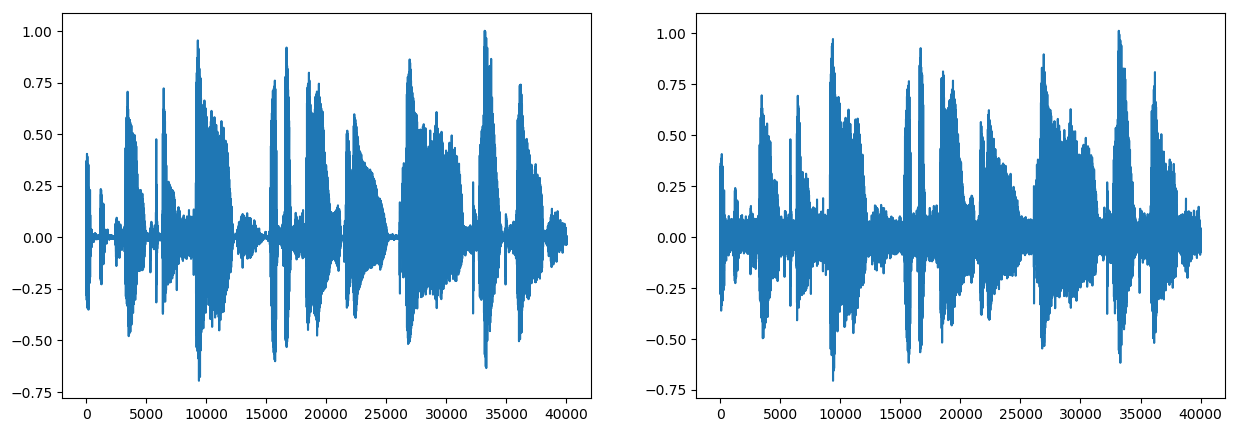

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004ACC37F0>

In [5]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech)
ax[2].plot(y_speech_n)

## SGMM training

### Train GMM on log power domain for initialization

In [6]:
function trainGMM(clusters::Int64, y::Array{Float64,2}, kind::Symbol)
    if (kind == :full) & isposdef(y)
        g = GMM(clusters, y, kind=kind)
        p = GMMprior(g.d, 0.1, 1.0)  ## set α0=0.1 and β0=1, and other values to a default
        v = VGMM(g, p) ## initialize variational GMM v with g
        em!(v, y)
    elseif (kind == :full) & ~isposdef(y)
        println("data matrix not posdef, going for diagonal GMM")
        g = GMM(clusters, y, kind=:diag)
        em!(g, y)
    else
        g = GMM(clusters, y, nIter=50, nInit=100, kind=:diag)
        em!(g, y)
    end
    return g
end;

In [60]:
# train GMMs 
Ns = 25
g_speech = trainGMM(Ns, z_speech, :diag)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       5.776538e+05
      1       3.439560e+05      -2.336978e+05 |       25
      2       3.337764e+05      -1.017964e+04 |       25
      3       3.306319e+05      -3.144472e+03 |       24
      4       3.288267e+05      -1.805176e+03 |       24
      5       3.273177e+05      -1.509042e+03 |       24
      6       3.257607e+05      -1.556951e+03 |       21
      7       3.248668e+05      -8.939083e+02 |       22
      8       3.244031e+05      -4.637866e+02 |       23
      9       3.241623e+05      -2.407297e+02 |       23
     10       3.240421e+05      -1.202189e+02 |       18
     11       3.239808e+05      -6.133465e+01 |       16
     12       3.239244e+05      -5.635898e+01 |       16
     13       3.238698e+05      -5.463514e+01 |       17

┌ Info: Initializing GMM, 25 Gaussians diag covariance 41 dimensions using 3992 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:78



     14       3.238046e+05      -6.513021e+01 |       15
     15       3.237431e+05      -6.153094e+01 |       13
     16       3.236972e+05      -4.593019e+01 |       11
     17       3.236736e+05      -2.354225e+01 |        5
     18       3.236574e+05      -1.626951e+01 |        8
     19       3.236324e+05      -2.502025e+01 |        6
     20       3.236138e+05      -1.851804e+01 |        4
     21       3.236051e+05      -8.687844e+00 |        6
     22       3.235777e+05      -2.743390e+01 |        9
     23       3.235489e+05      -2.876737e+01 |        8
     24       3.235428e+05      -6.124881e+00 |        4
     25       3.235282e+05      -1.464318e+01 |        5
     26       3.235164e+05      -1.181124e+01 |        4
     27       3.235003e+05      -1.607062e+01 |        3
     28       3.234920e+05      -8.288867e+00 |        3
     29       3.234878e+05      -4.161020e+00 |        3
     30       3.234787e+05      -9.170196e+00 |        3
     31       3.234744e+05    

┌ Info: K-means with 3992 data points using 34 iterations
│ 3.8 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\bTNkf\src\train.jl:139


GMM{Float64} with 25 components in 41 dimensions and diag covariance
⋮


### Function for SGMM EM algorithm

In [61]:
# initialize parameters
function initialize_parameters(g, z)
    
    # initialize μ
    μ = collect(g.μ')
    
    # initialize ν
    ν = 1 ./ g.Σ'
    
    # initialize ps
    ps = g.w
    
    # initialize ξ
    ξ = repeat(transpose(z), outer=[1,1,g.n])

    # initialize ϕ
    ϕ = ones(g.d, g.nx, g.n)
    
    # initialize f
    f = Array{Float64, 3}(undef, g.d, g.nx, g.n)
    
    # initialize qs
    qs = ones(g.nx, g.n) / g.n
    
    return ξ, ϕ, f, qs, μ, ν, ps
    
end
ξ, ϕ, f, qs, μ, ν, ps = initialize_parameters(g_speech, z_speech);

In [62]:
function update_ξ(ξ::Array{Float64,3}, ϕ::Array{Float64,3}, X::Array{Complex{Float64},2}, ν::Array{Float64,2}, μ::Array{Float64,2})::Array{Float64,3}
    for k = 1:size(ξ,1)
        for t = 1:size(ξ,2)
            for s = 1:size(ξ,3)
                @inbounds ξ[k,t,s] = ξ[k,t,s] + 1/ϕ[k,t,s]*( exp(-ξ[k,t,s])*abs2(X[k,t]) - ν[k,s]*ξ[k,t,s] + ν[k,s]*μ[k,s] - 1 ) 
            end
        end
    end
    return ξ
end

update_ξ (generic function with 1 method)

In [63]:
function update_ϕ(ϕ::Array{Float64,3}, ξ::Array{Float64,3}, X::Array{Complex{Float64},2}, ν::Array{Float64,2})::Array{Float64,3}
    for k = 1:size(ξ,1)
        for t = 1:size(ξ,2)
            for s = 1:size(ξ,3)
                @inbounds ϕ[k,t,s] = exp(-ξ[k,t,s])*abs2(X[k,t]) + ν[k,s]
            end
        end
    end
    return ϕ
end

update_ϕ (generic function with 1 method)

In [64]:
function update_f(f::Array{Float64,3}, ξ::Array{Float64,3}, ϕ::Array{Float64,3}, X::Array{Complex{Float64},2}, ν::Array{Float64,2}, μ::Array{Float64,2})::Array{Float64,3}
    for k = 1:size(ξ,1)
        for t = 1:size(ξ,2)
            for s = 1:size(ξ,3)
                @inbounds f[k,t,s] = 0.5*log(ν[k,s]) - log(pi) - 0.5*log(ϕ[k,t,s]) - exp(-ξ[k,t,s] + 1/(2*ϕ[k,t,s])) * abs2(X[k,t]) - ξ[k,t,s] - ν[k,s]/2*(1/ϕ[k,t,s] + (ξ[k,t,s] - μ[k,s])^2) + 0.5
            end
        end
    end
    return f
end

update_f (generic function with 1 method)

In [65]:
function update_qs(qs::Array{Float64,2}, ps::Array{Float64,1}, f::Array{Float64,3})
    F = 0.0
    for t = 1:size(f,2)
        for s = 1:size(f,3)
            @inbounds qs[t,s] = exp(sum(f[:,t,s]))*ps[s]
        end
        Zt = sum(qs[t,:])
        qs[t,:] = qs[t,:] / Zt
        F = F + log(Zt)
    end
    return qs, F
end

update_qs (generic function with 1 method)

In [66]:
function update_μ(μ::Array{Float64,2}, qs::Array{Float64,2}, ξ::Array{Float64,3})
    for k = 1:size(ξ, 1)
        for s = 1:size(ξ, 3)
            @inbounds μ[k,s] = sum(qs[:,s].*ξ[k,:,s])/sum(qs[:,s])
        end
    end
    return μ
end

update_μ (generic function with 1 method)

In [67]:
function update_ν(ν::Array{Float64,2}, qs::Array{Float64,2}, μ::Array{Float64,2}, ξ::Array{Float64,3}, ϕ::Array{Float64,3})
    for k = 1:size(ξ, 1)
        for s = 1:size(ξ, 3)
            @inbounds ν[k,s] = sum(qs[:,s])/sum(qs[:,s] .* ((ξ[k,:,s] .- μ[k,s]).^2 + 1 ./ ϕ[k,:,s]))
        end
    end
    return ν
end

update_ν (generic function with 1 method)

In [68]:
function update_ps(qs::Array{Float64,2})
    return squeeze(sum(qs, dims=1)) / sum(qs)
end

update_ps (generic function with 1 method)

In [69]:
function Estep(X::Array{Complex{Float64},2}, ξ::Array{Float64,3}, ϕ::Array{Float64,3}, ν::Array{Float64,2}, μ::Array{Float64,2}, f::Array{Float64,3}, qs::Array{Float64,2}, ps::Array{Float64,1})
    
    ξ = update_ξ(ξ, ϕ, X, ν, μ)
    ϕ = update_ϕ(ϕ, ξ, X, ν)
    f = update_f(f, ξ, ϕ, X, ν, μ)
    qs, F = update_qs(qs, ps, f)
    return ξ, ϕ, f, qs, F
end

Estep (generic function with 1 method)

In [70]:
function Mstep(μ::Array{Float64,2}, ν::Array{Float64,2}, qs::Array{Float64,2}, ξ::Array{Float64,3}, ϕ::Array{Float64,3})
    μ = update_μ(μ, qs, ξ)
    ν = update_ν(ν, qs, μ, ξ, ϕ) 
    ps = update_ps(qs)
    return μ, ν, ps
end

Mstep (generic function with 1 method)

## Train SGMM

In [71]:
ξ, ϕ, f, qs, μ, ν, ps = initialize_parameters(g_speech, z_speech)
Fmem = Float64[]
# specify data
X = collect(transpose(fr_speech))
for _=1:100
    ξ, ϕ, f, qs, F = Estep(X, ξ, ϕ, ν, μ, f, qs, ps)
    push!(Fmem, F)
    μ, ν, ps = Mstep(μ, ν, qs, ξ, ϕ)
end
;

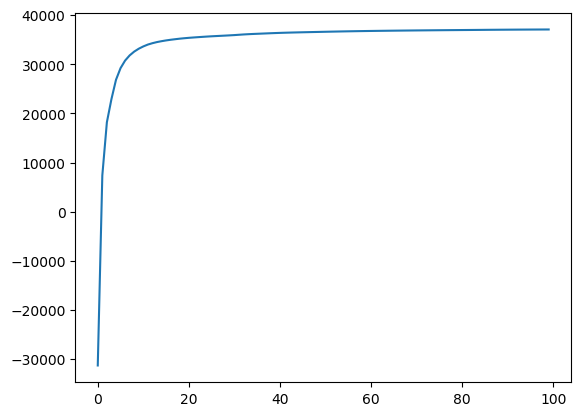

(PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x000000006A188978>], 37064.82897457872)

In [72]:
plt.plot(Fmem), Fmem[end]

## Variational Bayesian Inference

### Functions

In [73]:
function VB_initialize(Y::Array{Complex{Float64},1}, γ::Array{Float64,1}, ν::Array{Float64,2}, g)
    
    # Initialize ξ
    ξ::Array{Float64,2} = repeat(log.(abs2.(Y)), outer=[1, g.n])
    
    # Initialize ϕ
    ϕ = Array{Float64,2}(undef, g.d, g.n)
    for k = 1:g.d
        for s = 1:g.n
            ϕ[k,s] = γ[k] + exp(-ξ[k,s])
        end
    end
    
    # Initialize X
    X = Array{Complex{Float64},2}(undef, g.d, g.n)
    for k = 1:g.d
        for s = 1:g.n
            X[k,s] = γ[k] / ϕ[k,s] * Y[k]
        end
    end
        
    # Initialize ψ
    ψ = exp.(-ξ) .* (abs2.(X) + 1 ./ ϕ) + ν
    
    return ξ, ϕ, X, ψ
end

VB_initialize (generic function with 1 method)

In [74]:
function VB_update_qX(X::Array{Complex{Float64},2}, ϕ::Array{Float64,2}, Y::Array{Complex{Float64},1}, γ::Array{Float64,1}, ξ::Array{Float64,2}, ψ::Array{Float64,2})
    for k = 1:size(X,1)
        for s = 1:size(X,2)
            @inbounds ϕ[k,s] = γ[k] + exp(-ξ[k,s] + 1/2/ψ[k,s])
            @inbounds X[k,s] = γ[k]/ϕ[k,s]*Y[k]
        end
    end
    return X, ϕ
end

VB_update_qX (generic function with 1 method)

In [75]:
function VB_update_qξ(ξ::Array{Float64,2}, ψ::Array{Float64,2}, X::Array{Complex{Float64},2}, ϕ::Array{Float64,2}, ν::Array{Float64,2}, μ::Array{Float64,2})
    for k = 1:size(X,1)
        for s = 1:size(X,2)
            @inbounds ψ[k,s] = exp(-ξ[k,s])*(abs2(X[k,s]) + 1/ϕ[k,s]) + ν[k,s]
            @inbounds ξ[k,s] = ξ[k,s] + 1/ψ[k,s]*(exp(-ξ[k,s])*(abs2(X[k,s]) + 1/ϕ[k,s]) - ν[k,s]*(ξ[k,s] - μ[k,s]) - 1)
        end
    end
    return ξ, ψ
end

VB_update_qξ (generic function with 1 method)

In [76]:
function VB_posterior_mixture(Y::Array{Complex{Float64},1}, X::Array{Complex{Float64},2}, γ::Array{Float64,1}, ξ::Array{Float64,2}, ψ::Array{Float64,2}, ϕ::Array{Float64,2}, ν::Array{Float64,2}, μ::Array{Float64,2}, ps::Array{Float64,1})
    g = Array{Float64,2}(undef, size(X))
    for k = 1:size(X,1)
        for s = 1:size(X,2)
            @inbounds g[k,s] = log(γ[k]*sqrt(ν[k,s])/pi/ϕ[k,s]/sqrt(ψ[k,s])) - γ[k]*abs2(X[k,s]) + ϕ[k,s]*abs2(X[k,s])  - ξ[k,s] - ν[k,s]/2*((ξ[k,s] - μ[k,s])^2 + 1/ψ[k,s]) + 0.5
        end
    end
    Z::Float64 = sum(exp.(squeeze(sum(g, dims=1))).*ps)
    qs::Array{Float64,1} = exp.(squeeze(sum(g, dims=1))).*ps/Z
    return qs, log(Z)
end

VB_posterior_mixture (generic function with 1 method)

In [77]:
function VB_predict(Y::Array{Complex{Float64},1}, X::Array{Complex{Float64},2}, ξ::Array{Float64,2}, qs::Array{Float64,1})
    return X*qs, exp.(ξ*qs/2) .* exp.(1im*angle.(Y))
end

VB_predict (generic function with 1 method)

In [78]:
function VB_process_frame(Y, g, γ, μ, ν, ps, iterations)
    ξ, ϕ, X, ψ = VB_initialize(Y, γ, ν, g)
    qs = Array{Float64,1}(undef, g.n)
    for _ = 1:20
        ξ, ψ = VB_update_qξ(ξ, ψ, X, ϕ, ν, μ)
        X, ϕ = VB_update_qX(X, ϕ, Y, γ, ξ, ψ)
        qs, _ = VB_posterior_mixture(Y, X, γ, ξ, ψ, ϕ, ν, μ, ps)
    end
    return VB_predict(Y, X, ξ, qs)
end

VB_process_frame (generic function with 1 method)

In [79]:
f_pred1 = Array{Complex{Float64},2}(undef, size(fr_speech))
f_pred2 = Array{Complex{Float64},2}(undef, size(fr_speech))

γ = 2/nr_freqs*γ_noise*ones(g_speech.d) # changing this parameter has a large effect on residual noise
for k = 1:size(fr_speech,1)
    f_pred1[k,:], f_pred2[k,:] = VB_process_frame(fr_speech_n[k,:], g_speech, γ, μ, ν, ps, 20)
end

f_pred1 = fft_expand(f_pred1)
f_pred2 = fft_expand(f_pred2)

y_pred1 = warp_ifft(f_pred1, pole_location, step_size)
y_pred2 = warp_ifft(f_pred2, pole_location, step_size)
;

### Predictions based on frequency coefficients

<source src="data:audio/wav;base64,UklGRkBxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQRxAgA0gQm+oNpevvGHLb4D4Q2+KgnVvRe+cL2yJj49HNADPsdeWj5GxJc+bGm6PnTRtz5KIrI+iaGVPo/i6T3d2te8aNwXvb59nb1bzXO+FiCQvkGJLb42opS9RceRvWiiC70vCBY9w8GjPSYFNT1S4Z47B7thvQNXq71BK9e9W40RvpoRSb61Ska+b3EQvkkiz71vGqy9AX+PvHP/3z1dO10+nEyLPi/PqT5r/r0+yp+8PlQHoT4EbRQ+ZkLou18DJL3XGJG9BpBvvholnL5jTFm+DDmuvV7dpb0N2I69kfcuPOh6sz2MyI89wXgaPTUfmbve9Ta9yRvAvf9J+r253zG+cgZNvvKwL743vAG+SF++vWP3KbytiwU+FT18PiUlmT528LY+h9fOPmhhwj79kFc+4XkePdXXDjyDAxK9G/dVvj4vr77TeYW+V/IPvifJA77T9g2+tQ8Tvbpaxj0Zn/M9gjhlPbPLgzzUNAU9QIOePIa0pr38KzK+ZK87viTRHL55CRm+gScSvtQNl73I34c9XnBCPujthD6saJg+FmO9Pvp9yD7H5pM+ySWxPdvnZjmMrao7o+zavbwMnr5MxKa+qYtJvrxvF77CFi++ERvovSyY1ztfj5E9832MPYHqFD3SngU8yAdpPFHiRzz3CKO9KUEhvpkA773EtjK9CPJBvRBXT7taVyg+KkWgPhTMqj4I6K8+u4iYPgkmGz7UFZ49/tVJPfTE7r3pXpm+hTKHvnirN75wGFO+xHxhvmLExr0GUxc9KeGtPZSl4D1Hd+09mr+VPQX7gD12l3I9jlsYvdJKOL72mT2+tiH/vXN/K77XMGG+4O4Avi6RRDxXBG094G+xPdHUMD5LEHk+W0J6PumUSj7DNyg+KzryPbp0ij2giwq8d4dhvYG1bL3D/Km9i4QdvpSbG77eab+92rezvb1H3r1ZtXO9rDg3POpgN7qKRSm9Lw87vWna3rxy1be8R56pvFZOL7uIvVE9qjwRPuEKZD6l7Ik+3e6hPmf0sz4yClM+acYyPMtf0jsaYao8oqM/vmMDtL7Sp2e+QDbSvTmfO77QU1O+NGTFvDSh/T32/PQ9+i/SPagvIz4JvD0+Ts0aPkEPhj19E5q8lk6ivU91v73L7gG+W/w+vu3NPr4FGd29aE9rvXNbf73BbAG9Zk4SPc2KkT0lmzk94U0PPbRjGz0QWO48dmiXvMJ3UL2JjzO9B2fkvEgaDL18JCG93goIvVORcbxG4Mk7VNEBPAnDQ7v62gK7MJpkPOF7bDuzR7i8TAgRvU4LX7x97Va8LXqhvNmBOjtvAPY80eIKPUsGGj2sTFc9q2R8Pdoaez0/+y09SB3yPI7ZpTxsrXI8NQWBvFTtM72Fbz+9GaRCvZXJi720+Zi9N5FjvVBSS71YGVK9uWAnvSC9sLybF6O8j6BRvDNfGzq6GEs8YgaePK2/Nj15xoE9iNaCPX/vmj1Y6809EwPHPVcWoj1tQGg9TtspPYIFiDz+ALq8kCCDvaiz0b3cGvC9+VHxvYMMAL54zQy+KUPfvZp3mb2uDnK9D0QwvecLSrymCx48eg/hPEoSMD12q1U9iPqVPS387j0oJhY+jwIuPqmPPz77ADM+sHzuPW2Jmz3h3ig9AthuvSlwD76zMR++j7wivn6PWr7y52K+l1givj0C572Y/t69YZKYveOky7sEAuU8M8gaPRM4eT1OPME90iPiPfdy+T1qbh8+CP1JPtZ9aj7HsVo+SiLYPfXA0TzlY0k9xraVPD/eC75aP0a+VvC5vQGcwb2qBEa+Wj8dvrEcnbz06x68t0c4vVMiAT0Zqds9P82kPQ1GPj0QKJQ9hreCPQ0Vn7uocSS9b+IBvfCWZ71pz8C9Yky+vTxPpr2iQ5m9Sg+AvSnaJ71fpZO8xrc/vBTea7xe/8G7vf8gPNqgbTxmw++70oSOu4IqJDx80yo6O+Z3vE32zTpt0XM7wu9vvAAGkrxOGiu8EwQbvKEf/rsVkQ66yPjWO0od2TviHTI8kpUXPNCrwDxwnh89bSH5POaCijwodME8XtgHPVAKojw51ok8DwjNPHDViTzq/Jc6UdHTOTvjRrv8UhC8ADsKvC75F7zvvOy79osfvD2Mg7t73m669uLXumQtxzslmdE71WXlOwNRojy5hpk8tb8XPDp3vTyVYOI83iwrPMeh8zsVz8o8yvzFPERvJTxzMwk84cVEOzBEmjqOT408GA+xOxunerym1NA6ximHPJyBWroedru7oSn5Ozj+ozqzKqw7yOcdPJuzIDvCfxY7XQZPPFU5czzqUhA74dcJPJRtQjxCkzI8et+3PAomxroALIo8UxTpPJPOyDulnKI8XqyUPKj0j7sDHWA821i7POcZsbtU54e8RJEUOy0jEbzb5Tu8sDmHO1D99bs2+R67Z4AnPDP2zrxMSS+8WVcIPW0JHDzvUBe9dLGbvOaLFj0m+8o7i90wvbL4dzwwC6s8HNo6vbzbGDw1qgk986Euvd7TFL3hP+U8UCkavFZlOb0ASr68bdlTOoSMzLzE11a8bkV6vFuz5Ly1E+07r1ZXPNcyPL0B3JO8mwfmPM4TlbzcCvu8RFpUO0S2S7pyi5+8wRSSvDcRvTuEOUO86DznvK0pSrw0noi7WsxzvAA/67wnl0+8VzUfvEslXbyongu8TlChuxQWbbpzcDy7lBdau0BgELspBYQ7LThZugBE7rst9pi6Ux3JuoNvMrqtEva7pYnluw++qrsBjF67M+fKOq0RijqT2dS4J8dTOwSfszsSnIW7349Vuzu0ZLt67A68UrAqvDaSHLxDxgG8iERivBsvZ7wF1hG8Iph7u8eg+brQcl+7L4LNOyOaNTyrJNU7AlKJO7+mBTz/Wcg7ZgMZO+bOZDt4P5o6aEWOOUYXaTqczHm6q9d+ugHfAbs9XkQ540MnO6bDQruzx8K7ikTIu6jABry/6QC8dXYMvBuNk7sx+tO5TNRMO26onjsQtqi5GC6PO51QDTzfyM871n3euYxbDjsSD+w730gRO/ADNrtM0Gc7j8/VO21LbztfZom6UNGJO4IbwTvhSfI7y1QIPJP0ODynMTE8WbwnPJrMLzwCEv47je8BPPyjAzxP9B47px2VO/27wDtaGwY8afI2PKGH8DsAO+c737wDPCyn5Ts4msg7D8rRO4qrMzzHDxs8GmGRO0HZ5jtPjQ48dnTpO6AwWzxH+3E8FW0sPAVxCTzKsTY8gmK2O0y1dTueaLM7x3lauyoisrucf/q7xRGHuyoUq7tKdGC7SxBTOzsVYju98iE622j+OopHLjvUxCi6P7i5u88d5rviqiS8Tb4bvFP4RLxtEoK8KGmNvETVcrzeQIm8jwWRvGofSbxOFG28kKyAvMbAhLzuCXq8J6uWvDMAoLwqLZy8Ix6xvJwIpbwm+aK8jC+ZvKCSsry6h2e8KM9HvH03ibyvCVa86N5RvMz0MLxLCXy8USucvLW0nLxFj5i8UcZzvMJ4f7xsmXi8U89wvC61aLwU2Ie8IQqPvF5oarxBvTC8UYd0vDyhWbyasxy8xUcRvOTEGbyD+ne7zaj/uxr9Jrx9/em7CQ11u86Zi7t6gGq75sTWuxVgObs54cW3Qb4Du+w7rjqf8kc6B5AjO8a/Wjti3nk6jS88O52yNjsFvau75N4cupzKbTrgxeE6322SOucocTsn8N07moqEO7wpvjuNzys8GlgFPAjzRTzko2Y8eSQgPJU1OTydQgU84PUxPKg6EDwGkho8yJo/PLL+6jtKYuo7oxsbPOoHWTwpoxY8tc02PCZ2cTx2yS48DNwIPPmNTDw5E2c8M4yDPIZmeDwdL208K3liPEiEkzx2bYc80Yw+PK/5OTzaD

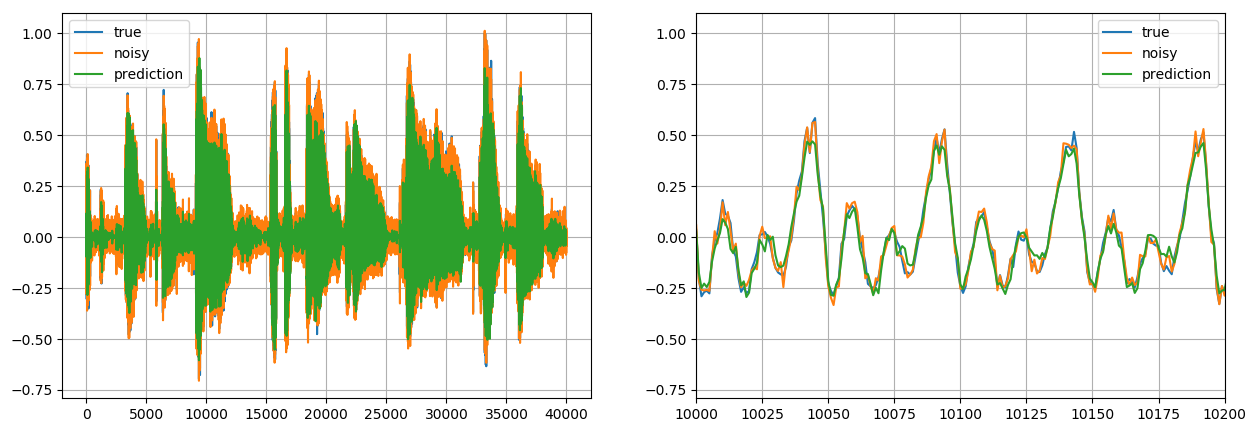

In [80]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech, label="true")
ax[1].plot(y_speech_n, label="noisy")
ax[1].plot(y_pred1, label="prediction")
ax[2].plot(y_speech, label="true")
ax[2].plot(y_speech_n, label="noisy")
ax[2].plot(y_pred1, label="prediction")
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([10000, 10200]), ax[1].legend(), ax[2].legend()
audioplayers(y_speech, y_speech_n, y_pred1, fs=fs_desired)

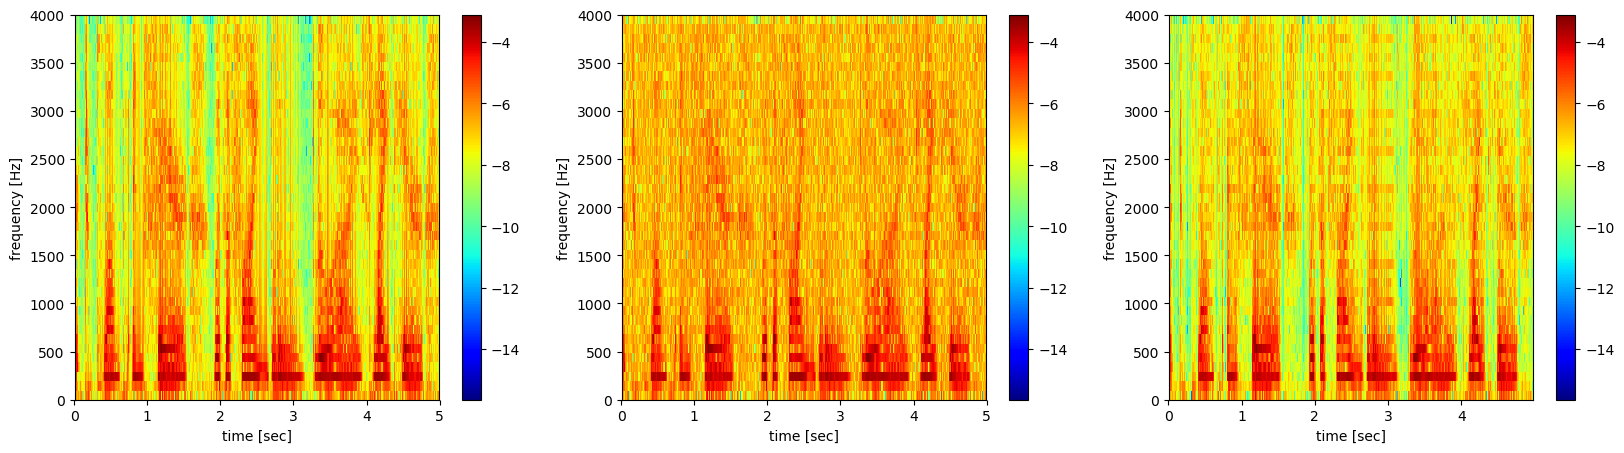

In [81]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
cmp = plot_spectrogram(spectrogram(y_speech, nr_freqs, nr_freqs-step_size, fs=fs_desired), fs_desired, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, nr_freqs, nr_freqs-step_size, fs=fs_desired), fs_desired, ax=ax[2])
plot_spectrogram(spectrogram(y_pred1, nr_freqs, nr_freqs-step_size, fs=fs_desired), fs_desired, ax=ax[3])
vrange = ax[1].get_images()[1].get_clim()
fig.colorbar(cmp, ax=ax[2])
ax[2].get_images()[1].set_clim(vrange)
fig.colorbar(cmp, ax=ax[3])
ax[3].get_images()[1].set_clim(vrange)
;

### Predictions based on log-spectrum

<source src="data:audio/wav;base64,UklGRkBxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQRxAgA0gQm+oNpevvGHLb4D4Q2+KgnVvRe+cL2yJj49HNADPsdeWj5GxJc+bGm6PnTRtz5KIrI+iaGVPo/i6T3d2te8aNwXvb59nb1bzXO+FiCQvkGJLb42opS9RceRvWiiC70vCBY9w8GjPSYFNT1S4Z47B7thvQNXq71BK9e9W40RvpoRSb61Ska+b3EQvkkiz71vGqy9AX+PvHP/3z1dO10+nEyLPi/PqT5r/r0+yp+8PlQHoT4EbRQ+ZkLou18DJL3XGJG9BpBvvholnL5jTFm+DDmuvV7dpb0N2I69kfcuPOh6sz2MyI89wXgaPTUfmbve9Ta9yRvAvf9J+r253zG+cgZNvvKwL743vAG+SF++vWP3KbytiwU+FT18PiUlmT528LY+h9fOPmhhwj79kFc+4XkePdXXDjyDAxK9G/dVvj4vr77TeYW+V/IPvifJA77T9g2+tQ8Tvbpaxj0Zn/M9gjhlPbPLgzzUNAU9QIOePIa0pr38KzK+ZK87viTRHL55CRm+gScSvtQNl73I34c9XnBCPujthD6saJg+FmO9Pvp9yD7H5pM+ySWxPdvnZjmMrao7o+zavbwMnr5MxKa+qYtJvrxvF77CFi++ERvovSyY1ztfj5E9832MPYHqFD3SngU8yAdpPFHiRzz3CKO9KUEhvpkA773EtjK9CPJBvRBXT7taVyg+KkWgPhTMqj4I6K8+u4iYPgkmGz7UFZ49/tVJPfTE7r3pXpm+hTKHvnirN75wGFO+xHxhvmLExr0GUxc9KeGtPZSl4D1Hd+09mr+VPQX7gD12l3I9jlsYvdJKOL72mT2+tiH/vXN/K77XMGG+4O4Avi6RRDxXBG094G+xPdHUMD5LEHk+W0J6PumUSj7DNyg+KzryPbp0ij2giwq8d4dhvYG1bL3D/Km9i4QdvpSbG77eab+92rezvb1H3r1ZtXO9rDg3POpgN7qKRSm9Lw87vWna3rxy1be8R56pvFZOL7uIvVE9qjwRPuEKZD6l7Ik+3e6hPmf0sz4yClM+acYyPMtf0jsaYao8oqM/vmMDtL7Sp2e+QDbSvTmfO77QU1O+NGTFvDSh/T32/PQ9+i/SPagvIz4JvD0+Ts0aPkEPhj19E5q8lk6ivU91v73L7gG+W/w+vu3NPr4FGd29aE9rvXNbf73BbAG9Zk4SPc2KkT0lmzk94U0PPbRjGz0QWO48dmiXvMJ3UL2JjzO9B2fkvEgaDL18JCG93goIvVORcbxG4Mk7VNEBPAnDQ7v62gK7MJpkPOF7bDuzR7i8TAgRvU4LX7x97Va8LXqhvNmBOjtvAPY80eIKPUsGGj2sTFc9q2R8Pdoaez0/+y09SB3yPI7ZpTxsrXI8NQWBvFTtM72Fbz+9GaRCvZXJi720+Zi9N5FjvVBSS71YGVK9uWAnvSC9sLybF6O8j6BRvDNfGzq6GEs8YgaePK2/Nj15xoE9iNaCPX/vmj1Y6809EwPHPVcWoj1tQGg9TtspPYIFiDz+ALq8kCCDvaiz0b3cGvC9+VHxvYMMAL54zQy+KUPfvZp3mb2uDnK9D0QwvecLSrymCx48eg/hPEoSMD12q1U9iPqVPS387j0oJhY+jwIuPqmPPz77ADM+sHzuPW2Jmz3h3ig9AthuvSlwD76zMR++j7wivn6PWr7y52K+l1givj0C572Y/t69YZKYveOky7sEAuU8M8gaPRM4eT1OPME90iPiPfdy+T1qbh8+CP1JPtZ9aj7HsVo+SiLYPfXA0TzlY0k9xraVPD/eC75aP0a+VvC5vQGcwb2qBEa+Wj8dvrEcnbz06x68t0c4vVMiAT0Zqds9P82kPQ1GPj0QKJQ9hreCPQ0Vn7uocSS9b+IBvfCWZ71pz8C9Yky+vTxPpr2iQ5m9Sg+AvSnaJ71fpZO8xrc/vBTea7xe/8G7vf8gPNqgbTxmw++70oSOu4IqJDx80yo6O+Z3vE32zTpt0XM7wu9vvAAGkrxOGiu8EwQbvKEf/rsVkQ66yPjWO0od2TviHTI8kpUXPNCrwDxwnh89bSH5POaCijwodME8XtgHPVAKojw51ok8DwjNPHDViTzq/Jc6UdHTOTvjRrv8UhC8ADsKvC75F7zvvOy79osfvD2Mg7t73m669uLXumQtxzslmdE71WXlOwNRojy5hpk8tb8XPDp3vTyVYOI83iwrPMeh8zsVz8o8yvzFPERvJTxzMwk84cVEOzBEmjqOT408GA+xOxunerym1NA6ximHPJyBWroedru7oSn5Ozj+ozqzKqw7yOcdPJuzIDvCfxY7XQZPPFU5czzqUhA74dcJPJRtQjxCkzI8et+3PAomxroALIo8UxTpPJPOyDulnKI8XqyUPKj0j7sDHWA821i7POcZsbtU54e8RJEUOy0jEbzb5Tu8sDmHO1D99bs2+R67Z4AnPDP2zrxMSS+8WVcIPW0JHDzvUBe9dLGbvOaLFj0m+8o7i90wvbL4dzwwC6s8HNo6vbzbGDw1qgk986Euvd7TFL3hP+U8UCkavFZlOb0ASr68bdlTOoSMzLzE11a8bkV6vFuz5Ly1E+07r1ZXPNcyPL0B3JO8mwfmPM4TlbzcCvu8RFpUO0S2S7pyi5+8wRSSvDcRvTuEOUO86DznvK0pSrw0noi7WsxzvAA/67wnl0+8VzUfvEslXbyongu8TlChuxQWbbpzcDy7lBdau0BgELspBYQ7LThZugBE7rst9pi6Ux3JuoNvMrqtEva7pYnluw++qrsBjF67M+fKOq0RijqT2dS4J8dTOwSfszsSnIW7349Vuzu0ZLt67A68UrAqvDaSHLxDxgG8iERivBsvZ7wF1hG8Iph7u8eg+brQcl+7L4LNOyOaNTyrJNU7AlKJO7+mBTz/Wcg7ZgMZO+bOZDt4P5o6aEWOOUYXaTqczHm6q9d+ugHfAbs9XkQ540MnO6bDQruzx8K7ikTIu6jABry/6QC8dXYMvBuNk7sx+tO5TNRMO26onjsQtqi5GC6PO51QDTzfyM871n3euYxbDjsSD+w730gRO/ADNrtM0Gc7j8/VO21LbztfZom6UNGJO4IbwTvhSfI7y1QIPJP0ODynMTE8WbwnPJrMLzwCEv47je8BPPyjAzxP9B47px2VO/27wDtaGwY8afI2PKGH8DsAO+c737wDPCyn5Ts4msg7D8rRO4qrMzzHDxs8GmGRO0HZ5jtPjQ48dnTpO6AwWzxH+3E8FW0sPAVxCTzKsTY8gmK2O0y1dTueaLM7x3lauyoisrucf/q7xRGHuyoUq7tKdGC7SxBTOzsVYju98iE622j+OopHLjvUxCi6P7i5u88d5rviqiS8Tb4bvFP4RLxtEoK8KGmNvETVcrzeQIm8jwWRvGofSbxOFG28kKyAvMbAhLzuCXq8J6uWvDMAoLwqLZy8Ix6xvJwIpbwm+aK8jC+ZvKCSsry6h2e8KM9HvH03ibyvCVa86N5RvMz0MLxLCXy8USucvLW0nLxFj5i8UcZzvMJ4f7xsmXi8U89wvC61aLwU2Ie8IQqPvF5oarxBvTC8UYd0vDyhWbyasxy8xUcRvOTEGbyD+ne7zaj/uxr9Jrx9/em7CQ11u86Zi7t6gGq75sTWuxVgObs54cW3Qb4Du+w7rjqf8kc6B5AjO8a/Wjti3nk6jS88O52yNjsFvau75N4cupzKbTrgxeE6322SOucocTsn8N07moqEO7wpvjuNzys8GlgFPAjzRTzko2Y8eSQgPJU1OTydQgU84PUxPKg6EDwGkho8yJo/PLL+6jtKYuo7oxsbPOoHWTwpoxY8tc02PCZ2cTx2yS48DNwIPPmNTDw5E2c8M4yDPIZmeDwdL208K3liPEiEkzx2bYc80Yw+PK/5OTzaD

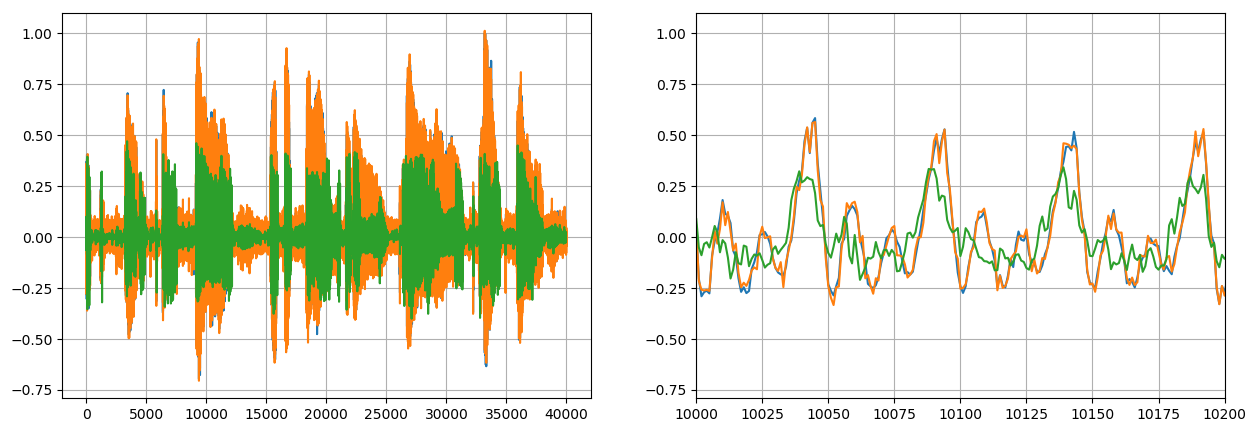

In [82]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech)
ax[1].plot(y_speech_n)
ax[1].plot(y_pred2)
ax[2].plot(y_speech)
ax[2].plot(y_speech_n)
ax[2].plot(y_pred2)
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([10000, 10200])
audioplayers(y_speech, y_speech_n, y_pred2, fs=fs_desired)

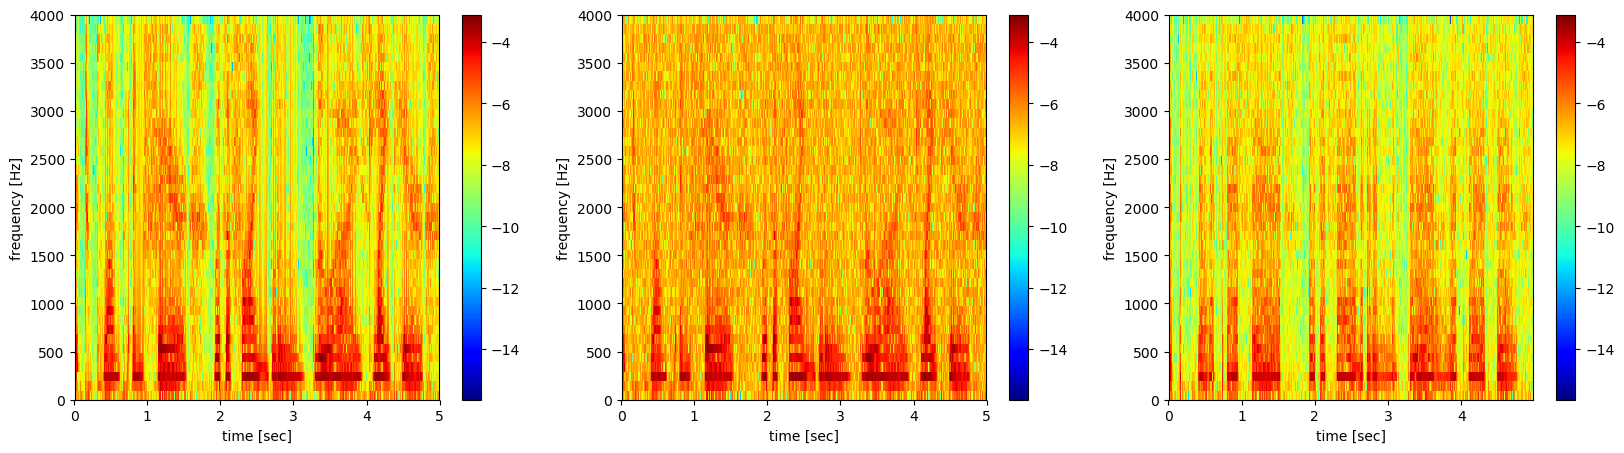

In [83]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
cmp = plot_spectrogram(spectrogram(y_speech, nr_freqs, nr_freqs-step_size, fs=fs_desired), fs_desired, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, nr_freqs, nr_freqs-step_size, fs=fs_desired), fs_desired, ax=ax[2])
plot_spectrogram(spectrogram(y_pred2, nr_freqs, nr_freqs-step_size, fs=fs_desired), fs_desired, ax=ax[3])
vrange = ax[1].get_images()[1].get_clim()
fig.colorbar(cmp, ax=ax[2])
ax[2].get_images()[1].set_clim(vrange)
fig.colorbar(cmp, ax=ax[3])
ax[3].get_images()[1].set_clim(vrange)
;

In [87]:
using ForneyLab
@RV test1
ifft(test1)

MethodError: MethodError: no method matching ifft(::Variable)
Closest candidates are:
  ifft(!Matched::AbstractArray{#s28,N} where N where #s28<:Real) at C:\Users\s151781\.julia\packages\AbstractFFTs\mhQvY\src\definitions.jl:198
  ifft(!Matched::AbstractArray{#s27,N} where N where #s27<:Real, !Matched::Any) at C:\Users\s151781\.julia\packages\AbstractFFTs\mhQvY\src\definitions.jl:198
  ifft(!Matched::AbstractArray{#s22,N} where N where #s22<:(Complex{#s21} where #s21<:Union{Integer, Rational})) at C:\Users\s151781\.julia\packages\AbstractFFTs\mhQvY\src\definitions.jl:200
  ...